In [23]:
%reload_ext autoreload
%autoreload 2
%run startup.py
from tqdm.auto import tqdm
from random import random 
from pytplan.gsolver import accel_acd, accel_xt
from pytplan.planner import  Joint, SegmentList
from pytplan.plot import *
from random import random, randint, shuffle, choices
from tqdm.auto import tqdm




def grouper(n, iterable):
    it = iter(iterable)
    while True:
        chunk = tuple(islice(it, n))
        if not chunk:
            return
        yield chunk

In [13]:
# Check differences between two was of calculating values. 

rows = []
for v_0, v_c, v_1 in tqdm(list(product(velocities,velocities, velocities))):
    x_ad, t_ad = accel_acd(v_0, v_c, v_1, a_max)
    
    x_a, t_a = accel_xt(v_0, v_c, a_max)
    x_d, t_d = accel_xt(v_c, v_1, a_max)
    
    rows.append( dict(x = x_ad - (x_a+x_d), t = t_ad -(t_a+t_d) ))
    
df = pd.DataFrame(rows)
                
df.describe()
    

  0%|          | 0/13824 [00:00<?, ?it/s]

,x,t
count,13824.0,13824.0
mean,0.0,0.0
std,0.0,0.0
min,0.0,0.0
25%,0.0,0.0
50%,0.0,0.0
75%,0.0,0.0
max,0.0,0.0


In [14]:
# Test that values get passed through the Block sontructors. 

j = Joint(5_000, 50_000)
self = j.new_block(100,123,456)

assert self.x == 100, self.x
assert self.v_0 == 123
assert self.joint.v_max == 5_000

self = j.new_block(100,123,456)

assert self.x == 100
assert self.v_0 == 123
assert self.joint.v_max == 5_000


In [15]:

# Basic init and plan testing
#  - Initial planning
#  - Multiple updates to new time. 

j = Joint(5_000, 50_000)

n = 0
errors = []
rows = []
for i, (x, v_0, v_1) in tqdm(limits()): #choices(limits(),k=2_000):

    for _ in range(10):
        tf = random()*3+1.01 # Time factor, multiply with block time
        try:
            b = j.new_block(x, v_0, v_1)
            
            t = b.min_time()*tf
            b.plan(t)
            assert abs(b.area-b.x) < 3, (b.area, b.x, b, i)
         
            if b.t != t:
                ot = b.t
                b.plan(ot)
                #assert round(self.t, 6) == round(ot, 6), (self.t, t)
                
            a = b.area
        except:
            errors.append( (i, tf, b))
            raise
        d = dict(i=i, x=x, t=self.t, v_0=b.v_0, v_1=b.v_1, v_c=b.v_c, a=a)
        rows.append(d)
        
print(len(errors))
df = pd.DataFrame(rows)  
print('# rows =', len(df))

  0%|          | 0/11520 [00:00<?, ?it/s]

0
# rows = 115200


In [18]:
# Basic init and plan testing
#  - Initial planning
#  - Multiple updates to new time. 

j = Joint(5_000, 50_000)

n = 0
errors = []
rows = []
for i in tqdm(list(range(2_000))):

  
    x =   int(random() < .90)*randint(-10000,10000)
    v_0 = int(random() < .90)*randint(0, j.v_max)
    v_1 = int(random() < .90)*randint(0,j.v_max)
                
    for _ in range(10):
        tf = random()*3+1.01 # Time factor, multiply with block time
        a = x_e = None
        try:
            b = j.new_block(x, v_0, v_1)
            t = b.min_time()*tf
            b.plan(t)
            assert abs(b.area - b.x)<3, (b.area, self, i)
            if b.t != t:
                ot = b.t
                b.plan(ot)
               
            a = b.area
        except:
            errors.append( (i, x, v_0, v_1, tf))
            raise
        
        d = dict(i=i, x=x, t=self.t, v_0=b.v_0, v_1=b.v_1)
        rows.append(d)
        
df = pd.DataFrame(rows)  
print('# rows =', len(df), "# errors = ", len(errors) )
#df.qc.value_counts(normalize=True)

  0%|          | 0/2000 [00:00<?, ?it/s]

# rows = 20000 # errors =  0


In [19]:
if errors:
    (i, x, v_0, v_1, tf)  = errors[0]
    print(i, x, v_0, v_1)
    self = j.new_block(x, v_0, v_1).init()
    t = self.t*tf
    try:
        self.plan(t)
    except:
        print(t, self.x, self.t, self.v_0, self.v_1, tf)
        
if errors:
    (i,  (x, v_0, v_1), tf) = errors[0]
    print(x, v_0, v_1, tf)
    
    #(x, v_0, v_1, tf) =  10,250,750,1.231111111111111


    self = j.new_block(x, v_0, v_1).init()
    t = self.t

    self.plan(t * tf)
    self.plan_ramp(t*tf)
    
           
    self.plan(t * tf)
    self.plan_ramp(t*tf)
    
    print(self)
        

In [20]:

j = Joint(20_000, 500_000)
n = 6
joints = [j]*n
signs = [1]*n

sl = SegmentList(joints)   


def rand_move(axis):

    z = int(random() < .9) # Make 10% of the moves zero    
    signs[axis] = -signs[axis] if random() < .1 else signs[axis] # change direction_state 10% of the time

    return z * signs[axis] * randint(0,10000)
 
move_sets = [ [ rand_move(axis) for axis in range(len(joints))] for _ in range(1000) ]

for move_n, moves in tqdm(list(enumerate(move_sets))):
    try:
        sl.move(moves)
    except:
        print("Move=", move_n, move_sets[move_n])
        raise

def report_dis():
    ds = list(sl.discontinuities())
    if len(ds):
        print(f"Got {len(ds)} discontinuities") 
        for a, b in sl.discontinuities():
            be = sl.boundary_error(a.segment, b.segment)
            print(a.id, 'diff=',abs(a.v_1-b.v_0), a.v_1,'!=',b.v_0, "be=", be )

report_dis()
            

report(sl)

  0%|          | 0/1000 [00:00<?, ?it/s]

Got 3 discontinuities
42/0 diff= 58 59 != 1 be= 58.0
388/3 diff= 7 8 != 1 be= 7.0
892/1 diff= 14 18 != 4 be= 14.0


N Discont,3,N Replans,147594,Errors,[]
Reductions,"[('V1A', 9979), ('V1B', 7413), ('V0B', 6245), ('V0A', 5619)]",Replans,"[(2, 419), (4, 307), (6, 151), (14, 37), (8, 31), (7, 11), (9, 11), (5, 8), (10, 7), (11, 5)]",Time Err,0.2754


  0%|          | 0/100 [00:00<?, ?it/s]

3 [[-2871, 669, -2884, -8437], [-316, 4418, -5363, 148], [0, 574, -129, 4909], [1652, -5889, -8028, 7689], [8293, -4941, -7927, 6586]]
[[-2871, 669, -2884, -8437], [-316, 4418, -5363, 148], [0, 574, -129, 4909], [1652, -5889, -8028, 7689], [8293, -4941, -7927, 6586]]


/Users/eric/Documents/proj/tplan/python/pytplan/pytplan/plot.py:61: UserWarning: Found 1 discontinuities in axis 1
  warn(f"Found {discontinuities[0]} discontinuities in axis {axis}")
/Users/eric/Documents/proj/tplan/python/pytplan/pytplan/plot.py:61: UserWarning: Found 1 discontinuities in axis 2
  warn(f"Found {discontinuities[0]} discontinuities in axis {axis}")
/Users/eric/Documents/proj/tplan/python/pytplan/pytplan/plot.py:61: UserWarning: Found 1 discontinuities in axis 3
  warn(f"Found {discontinuities[0]} discontinuities in axis {axis}")


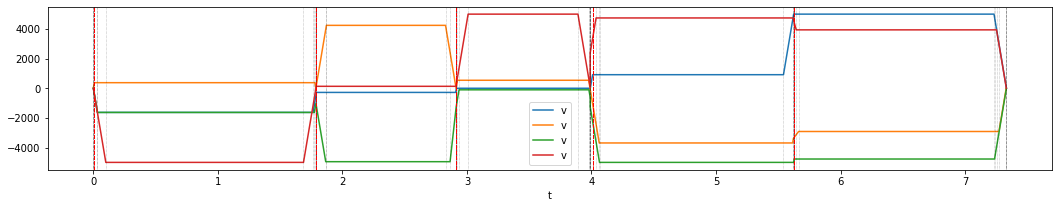

In [21]:
j = Joint(5_000, 50_000)
n = 4
joints = [j]*n
signs = [1]*n

def f():
    for i in tqdm(list(range(100))):
        sl = SegmentList(joints)  
        move_sets = [ [ rand_move(axis) for axis in range(len(joints))] for _ in range(5) ]


        for move_n, moves in enumerate(move_sets):
            try:
                sl.move(moves)
            except:
                print("Move=", move_n, move_sets[move_n])
                return move_sets

        if i > 5 and len(list(sl.discontinuities())):
            ds = list(sl.discontinuities())
            print(len(ds), move_sets)   
            sl.plot()
            return move_sets
    else:
        print("Got Nothing")

move_sets = f()
print(move_sets)

## R=10000 N=100 Tmean = 0.05620311881188119

N Discont,0,N Replans,4488,Errors,[]
Reductions,"[('V1A', 381), ('V1B', 70), ('V0A', 60), ('V0B', 40)]",Replans,"[(8, 95), (4, 2), (6, 2), (0, 1)]",Time Err,0.0048


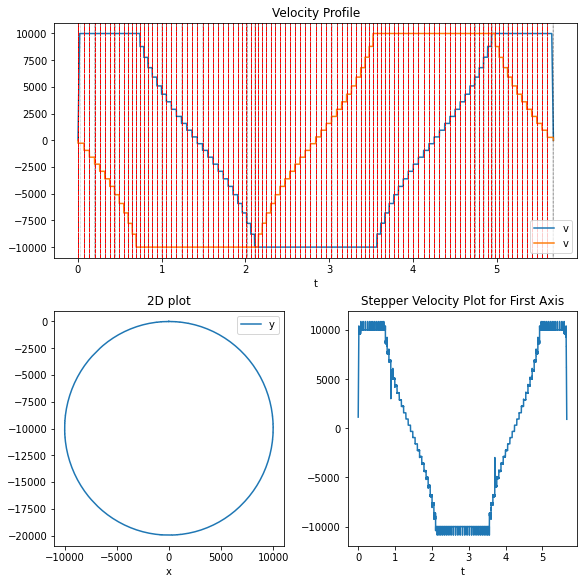

In [37]:
%reload_ext autoreload
%autoreload 2
%run startup.py
from math import sin, cos, sqrt
from pytplan.plot import  * 
from pytplan.planner import Segment, SegmentList, Joint
import numpy as np 
from IPython.display import Markdown 

# Acelleration should be about 30x the max velocity
 
j = Joint(10_000, 500_000)

def make_circle(j, r=5000, n=100):
   
    joints = [j]*2

    sl = SegmentList(joints)   
    r = r
    lx  = 0
    ly = r
    for i in range(0,n+1):
        a = 2*np.pi*(i/n)
        x = sin(a)*r 
        y = cos(a)*r 
        
        sl.move((round(x-lx),round(y-ly)))
        
        lx = x
        ly = y
            
    t_m = np.mean(list(chain(*[s.times for s in sl])))
    display(Markdown(f"## R={r} N={n} Tmean = {round(t_m, 4)}"))     

    #sl.plot();plt.show()
    #fig, ax = plt.subplots(1,figsize=(12,12))
    stepper_plot(sl)
    return sl
 
sl = make_circle(j, 10000, 100)

report(sl)

## R=5000 N=100 Tmean = 0.03016563366336634

N Discont,0,N Replans,4424,Errors,[]
Reductions,"[('V1A', 553), ('V0A', 80), ('V1B', 70), ('V0B', 52)]",Replans,"[(8, 46), (6, 40), (4, 9), (2, 4), (0, 1)]",Time Err,0.0066


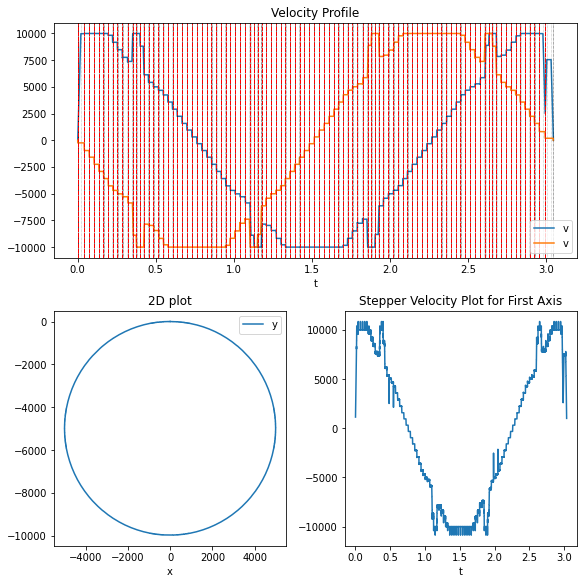

In [41]:
# Oh, this one is bad .... 
sl = make_circle(j, 5000, 100)

report(sl)

## R=5000 N=200 Tmean = 0.029427616915422887

N Discont,0,N Replans,11586,Errors,[]
Reductions,"[('V1A', 2367), ('V1B', 400), ('V0B', 145), ('V0A', 20)]",Replans,"[(8, 177), (6, 14), (4, 5), (2, 3), (0, 1)]",Time Err,0.0025


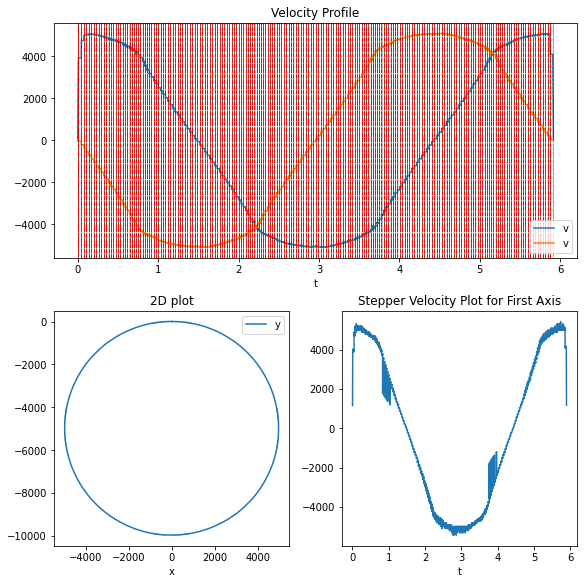

In [44]:
# But increasing N from 100 to 200 and it is much better. 
sl = make_circle(j, 5000, 200)

report(sl)